In [1]:
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import pandas as pd
import kagglehub
import numpy as np
import warnings
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

In [2]:
# Данные взяты с https://www.kaggle.com/datasets/ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset
df = pd.read_csv('../data/earthquake_data_tsunami.csv')
df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


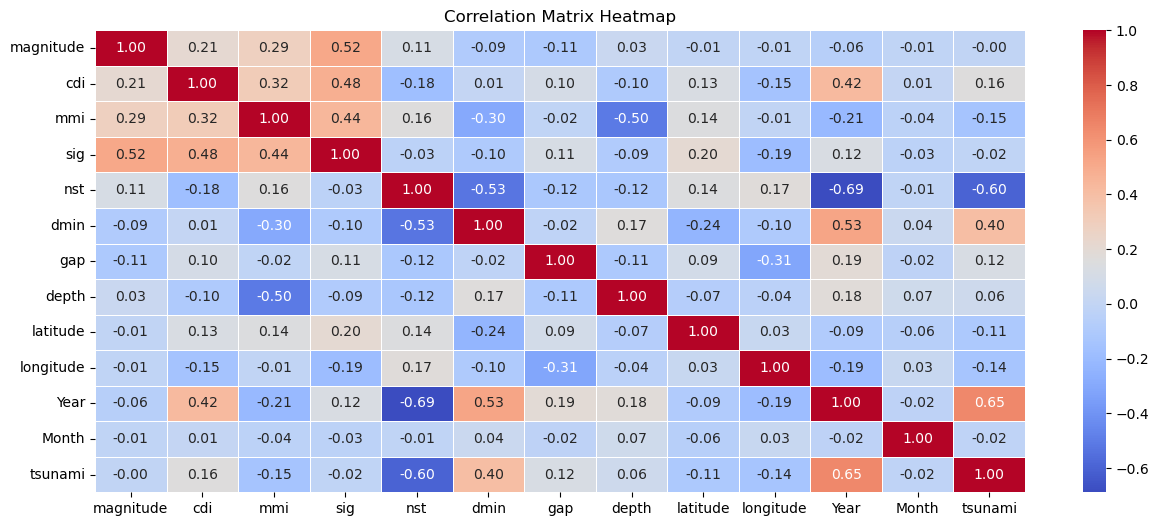

In [5]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(15, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [7]:
col_features = ['sig', 'magnitude', 'cdi', 'mmi', 'dmin', 'Year', 'depth']
df = df.sample(frac=1, random_state=42)
Y = df['tsunami']
X = df.drop('tsunami', axis=1)

X['mmi_impact'] = X['sig'] / X['mmi']


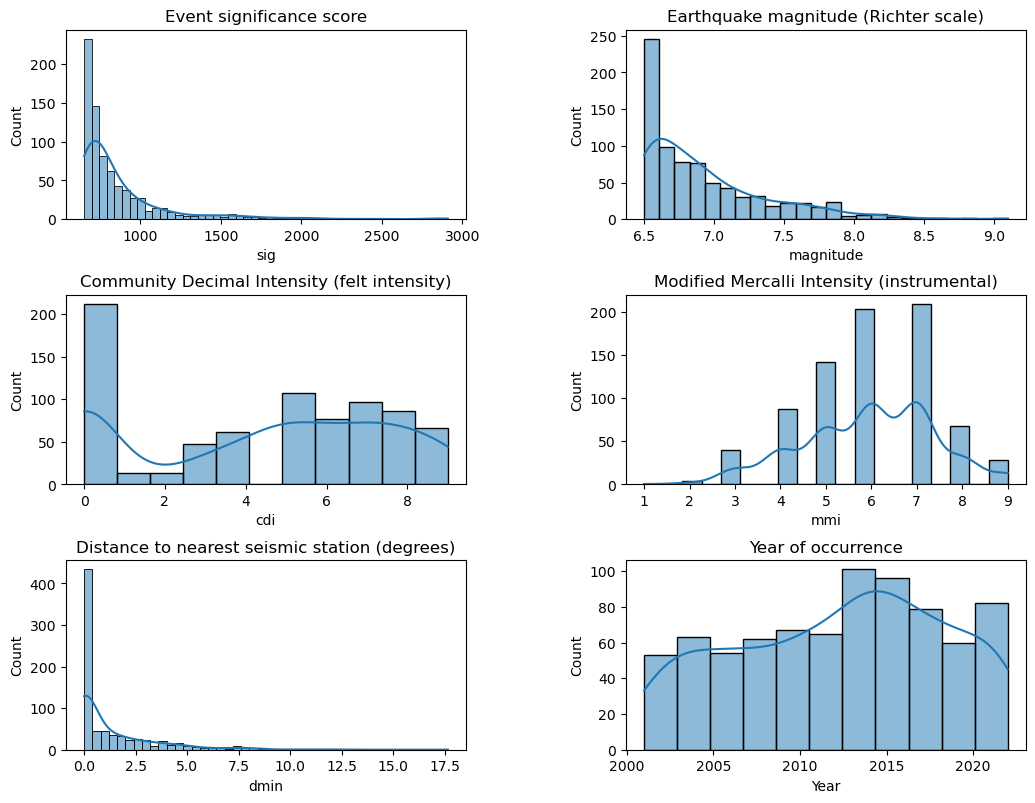

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

sns.histplot(data=X, x='sig', ax=axes[0, 0], kde=True) 
axes[0][0].set_title('Event significance score')

sns.histplot(data=X, x='magnitude', ax=axes[0, 1], kde=True) 
axes[0][1].set_title('Earthquake magnitude (Richter scale)')

sns.histplot(data=X, x='cdi', ax=axes[1, 0], kde=True) 
axes[1][0].set_title('Community Decimal Intensity (felt intensity)')

sns.histplot(data=X, x='mmi', ax=axes[1, 1], kde=True) 
axes[1][1].set_title('Modified Mercalli Intensity (instrumental)')

sns.histplot(data=X, x='dmin', ax=axes[2, 0], kde=True) 
axes[2][0].set_title('Distance to nearest seismic station (degrees)')

sns.histplot(data=X, x='Year', ax=axes[2, 1], kde=True) 
axes[2][1].set_title('Year of occurrence')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


In [11]:
split_idx = int(len(X) * 0.8)

X_array = X.values.astype(float) 
X_train, X_test = X_array[:split_idx], X_array[split_idx:]

Y_array = Y.values.astype(float) 
Y_train, Y_test = Y_array[:split_idx], Y_array[split_idx:]
 
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (625, 13), Test: (157, 13)


In [13]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

In [15]:
X_mean = X_train_tensor.mean(dim=0)
X_std = X_train_tensor.std(dim=0)
X_train_norm = (X_train_tensor - X_mean) / X_std
X_test_norm = (X_test_tensor - X_mean) / X_std

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

In [19]:
# БЫСТРЫЙ ТЕСТ С GRADIENT BOOSTING
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=6)
gb.fit(X_train, y_train)

gb_pred = gb.predict(X_test)
gb_r2 = r2_score(y_test, gb_pred)

print(f"Gradient Boosting R²: {gb_r2:.4f}") 

Gradient Boosting R²: 0.8176


In [21]:
model = nn.Sequential(
    nn.Linear(13, 128),  
    nn.BatchNorm1d(128),
    nn.SELU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.SELU(),
    nn.Dropout(0.2),
    nn.Linear(64, 32),
    nn.SELU(),
    nn.Dropout(0.2),
    nn.Linear(32, 16),
    nn.SELU(),
    nn.Dropout(0.1),
    nn.Linear(16, 1),
    nn.Sigmoid()
)
 
# Добавим L2 регуляризацию в оптимизатор - weight_decay=0.01
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001 ) #, weight_decay=0.01)
criterion = nn.BCELoss()

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2000)

print("Модель создана!")

Модель создана!


In [23]:
# Обучение модели

losses = []
val_losses = []
 
for epoch in range(5000): 
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_norm)  
    loss = criterion(predictions, Y_train_tensor.view(-1, 1)) 

    # Применим L1 регуляризацию
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    loss = loss + 0.0005 * l1_norm
    
    loss.backward()  
    optimizer.step()
    losses.append(loss.item())
     
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_norm)
        val_loss = criterion(val_pred, Y_test_tensor.view(-1, 1))
        scheduler.step(val_loss)
        val_losses.append(val_loss.item())
        
    if epoch % 200 == 0:
        print(f'Epoch {epoch:3d} | Train Loss: {loss.item():8.4f} | Val Loss: {val_loss.item():8.4f}')

Epoch   0 | Train Loss:   1.1838 | Val Loss:   0.6397
Epoch 200 | Train Loss:   0.5136 | Val Loss:   0.3550
Epoch 400 | Train Loss:   0.4329 | Val Loss:   0.3814
Epoch 600 | Train Loss:   0.4134 | Val Loss:   0.4000
Epoch 800 | Train Loss:   0.3867 | Val Loss:   0.3927
Epoch 1000 | Train Loss:   0.3395 | Val Loss:   0.3881
Epoch 1200 | Train Loss:   0.3512 | Val Loss:   0.3623
Epoch 1400 | Train Loss:   0.3142 | Val Loss:   0.3610
Epoch 1600 | Train Loss:   0.2728 | Val Loss:   0.3721
Epoch 1800 | Train Loss:   0.2927 | Val Loss:   0.3881
Epoch 2000 | Train Loss:   0.2889 | Val Loss:   0.3486
Epoch 2200 | Train Loss:   0.3002 | Val Loss:   0.3971
Epoch 2400 | Train Loss:   0.2729 | Val Loss:   0.3616
Epoch 2600 | Train Loss:   0.2619 | Val Loss:   0.3885
Epoch 2800 | Train Loss:   0.2987 | Val Loss:   0.3912
Epoch 3000 | Train Loss:   0.2818 | Val Loss:   0.3549
Epoch 3200 | Train Loss:   0.2587 | Val Loss:   0.4041
Epoch 3400 | Train Loss:   0.2560 | Val Loss:   0.3633
Epoch 3600 | Tr

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch.nn.functional as F

model.eval()
with torch.no_grad():
    test_pred_proba = model(X_test_norm)
    
    # Получаем бинарные предсказания (порог 0.5 по умолчанию)
    test_pred_binary = (test_pred_proba > 0.5).float()
    
    # Для метрик нужны numpy arrays
    y_true = Y_test_tensor.view(-1, 1).cpu().numpy()
    y_pred_binary = test_pred_binary.cpu().numpy()
    y_pred_proba = test_pred_proba.cpu().numpy()

# Основные метрики классификации
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)   
recall = recall_score(y_true, y_pred_binary)         
f1 = f1_score(y_true, y_pred_binary)
roc_auc = roc_auc_score(y_true, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Матрица ошибок - самая важная!
cm = confusion_matrix(y_true, y_pred_binary)
print("Confusion Matrix:")
print(cm)

Accuracy: 0.8790
Precision: 0.8387
Recall: 0.8525
F1-Score: 0.8455
ROC-AUC: 0.9392
Confusion Matrix:
[[86 10]
 [ 9 52]]
